# Latex export of plots
This notebook was used for creating **Figures 5** and **6** in the paper. If you run this notebook in the supplied docker container, do not run the cell `[2]` and all cells calling the `display_tikz` function. This code shows the final figures which requires $\LaTeX$ and [tikzmagic](https://github.com/xblahoud/tikzmagic) installed in the system. We did not supply them to keep the size of the docker conatiner reasonably small.

In [1]:
from ltlcross_wrapper import ResAnalyzer

In [2]:
import tikzmagic

def display_tikz(tikzcode, scale=1):
    preamble = r"""\usepackage{pgfplots}
\usepackage{xcolor}
"""
    return tikzmagic.tikzmagic.tikz(f"-s={scale} -b=0 -x='{preamble}'", tikzcode)

In [3]:
tool_set = ["yes.roll","yes.goal#fri","yes.goal#pit","yes.seminator#best","yes.spot"]
b = ResAnalyzer(f"data/random_nd.csv", cols=["states","time","acc","transitions"], tool_set=tool_set)
names = {
    "yes.seminator#best" : "Seminator 2",
    "yes.goal#pit" : "GOAL+Spot",
    "yes.goal#fri" : "Fribourg+Spot",
    "yes.roll" : "Roll+Spot",
    "yes.spot" : "Spot",
}

In [4]:
b.values.rename(columns=names, level=1, inplace=True)
b.tools = [names.get(t,t) for t in b.tools]
b.tool_set = [names.get(t,t) for t in b.tool_set]
b.exit_status.rename(columns=names, level=0, inplace=True)
args = {
    "width" : "5.5cm",
    "height" : "4.6cm",
    "log" : "both",
    "xlabel shift" : "-.1cm"
}

In [5]:
t1, t2 = "Spot","Seminator 2"
above = len(b.smaller_than(t1, t2))
below = len(b.smaller_than(t2, t1))
nodes = f"""%
\\draw[gray] (0,0) -- 
  node[above, sloped, magenta, pos=.5, font=\\tiny, align=center, inner sep=25pt] {{{t1}\\\\better in\\\\{above} cases}}
  node[below, sloped, magenta, pos=.5, font=\\tiny, align=center, inner sep=25pt] {{{t2}\\\\better in\\\\{below} cases}}
(130,130);
"""
labels = {
    "xlabel" : f"{{{t1} [\\#states]}}",
    "ylabel" : f"{{{t2} [\\#states]}}"
}
tikzcode = b.pgfplots_scatter_plot(t1,t2, marks_dict={"fill" : "cyan", "fill opacity" : .3}, **labels, tikz_hook=nodes, diagonal=True, **args)
!mkdir -p ../fig
print(tikzcode, file=open("../fig/spot_sem_nd.tikz", "w"))

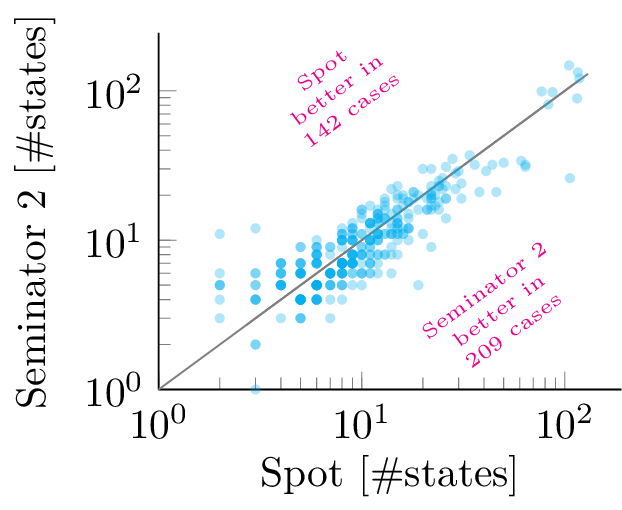

In [6]:
display_tikz(tikzcode)

In [7]:
t1, t2 = "Fribourg+Spot","Seminator 2"
above = len(b.smaller_than(t1, t2))
below = len(b.smaller_than(t2, t1))
nodes = f"""%
\\draw[gray] (0,0) -- 
  node[above, sloped, magenta, pos=.5, font=\\tiny, align=center, inner sep=25pt] {{{t1}\\\\better in\\\\{above} cases}}
  node[below, sloped, magenta, pos=.5, font=\\tiny, align=center, inner sep=25pt] {{{t2}\\\\better in\\\\{below} cases}}
(130,130);
"""
labels = {
    "xlabel" : f"{{{t1} [\\#states]}}",
    "ylabel" : f"{{{t2} [\\#states]}}"
}
tikzcode = b.pgfplots_scatter_plot(t1,t2, marks_dict={"fill" : "cyan", "fill opacity" : .3}, **labels, tikz_hook=nodes, diagonal=True, **args)
!mkdir -p ../fig
print(tikzcode, file=open("../fig/frib_sem_nd.tikz", "w"))

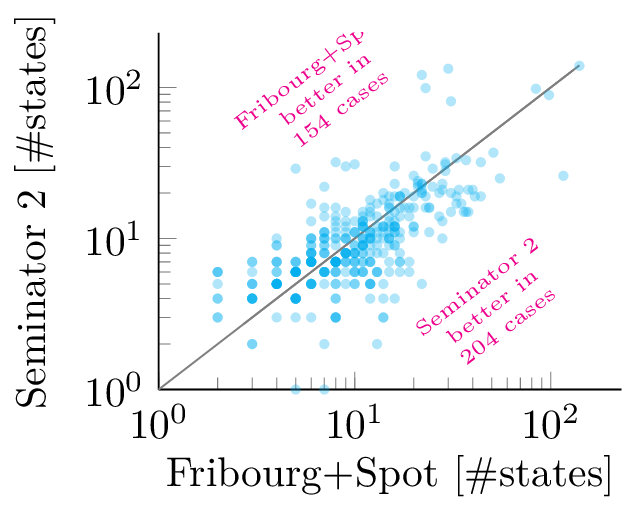

In [8]:
display_tikz(tikzcode)

## Cactus plot
This corresponds to **Figure 6** in the paper.

In [9]:
import pandas2pgfplots

In [10]:
tresh = 10
time = b.values.time.loc[:,b.tool_set]
data = time[(time["Fribourg+Spot"]>tresh) | (time["GOAL+Spot"]>tresh) | (time["Roll+Spot"]>tresh) | (time["Seminator 2"]>tresh) | (time["Spot"]>tresh)]

args = {
    "width" : "10cm",
    "height" : "4.6cm",
    "ylabel" : "seconds",
    "xlabel" : f"$n$-th fastest of the {len(data)} hardest inputs",
    "xlabel shift" : "-.1cm"
    
}
tikzcode = pandas2pgfplots.pandas2pgfplots.cactus(df=data, exclude_treshold=120,**args)
print(tikzcode, file=open("../fig/time_cactus.tikz", "w"))

In [11]:
len(data)

83

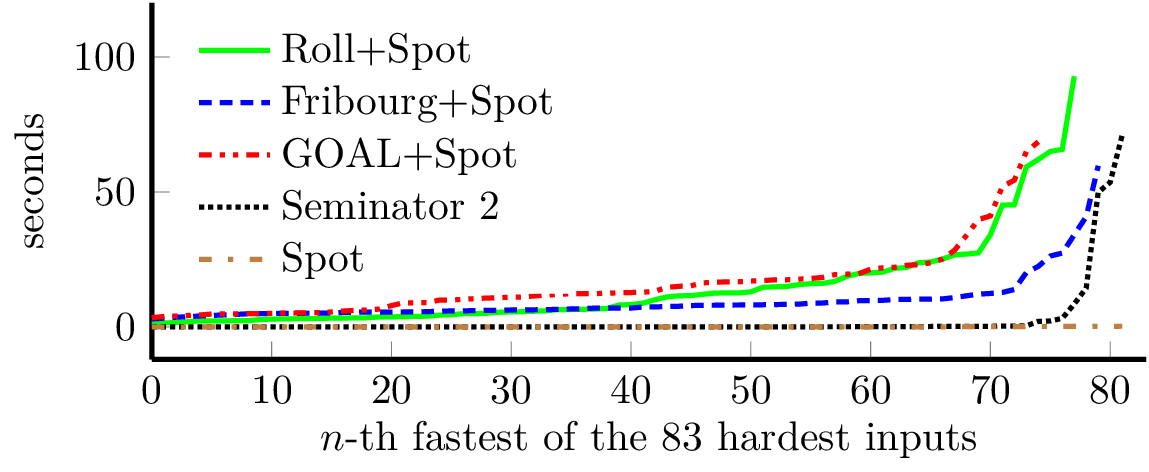

In [12]:
display_tikz(tikzcode)